In [2]:
import numpy as np
import pandas as pd

In [3]:
import os

In [4]:
base_data_dir = './data/alzheimer'
train_base_dir = f'{base_data_dir}/train'
test_base_dir = f'{base_data_dir}/test'

In [5]:
class_distributions = {}
classes = os.listdir(train_base_dir)

In [6]:
for class_name in classes:
    class_distributions[class_name] = len(os.listdir(f'{train_base_dir}/{class_name}'))

In [7]:
class_distributions

{'MildDemented': 717,
 'ModerateDemented': 52,
 'NonDemented': 2560,
 'VeryMildDemented': 1792}

In [8]:
from matplotlib import pyplot as plt
import matplotlib.animation as animation

#### Distribution of classes in the train dataset

([0, 1, 2, 3],
 [Text(0, 0, 'MildDemented'),
  Text(1, 0, 'ModerateDemented'),
  Text(2, 0, 'NonDemented'),
  Text(3, 0, 'VeryMildDemented')])

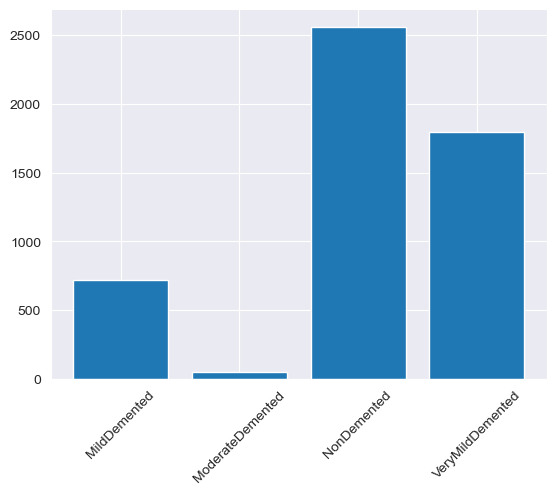

In [9]:
plt.bar(classes, class_distributions.values())
plt.xticks(rotation=45)

In [10]:
from PIL import Image

In [11]:
def get_image_dimensions(image_path):
    image = Image.open(image_path)
    return image.width, image.height

In [12]:
from tqdm import tqdm

In [13]:
class_dimensions_distributions = {
    'width': [],
    'height': [],
    'class': []
}

In [14]:
for class_name in classes:
    for image_name in tqdm(os.listdir(f'{train_base_dir}/{class_name}')):
        image_path = f'{train_base_dir}/{class_name}/{image_name}'
        image_width, image_height = get_image_dimensions(image_path)
        class_dimensions_distributions['width'].append(image_width)
        class_dimensions_distributions['height'].append(image_height)
        class_dimensions_distributions['class'].append(class_name)

100%|██████████| 1792/1792 [00:00<00:00, 1997.60it/s]


In [15]:
dimensions_df = pd.DataFrame(class_dimensions_distributions)
dim_df = pd.DataFrame(class_dimensions_distributions)

In [16]:
dimensions_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5121 entries, 0 to 5120
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   width   5121 non-null   int64 
 1   height  5121 non-null   int64 
 2   class   5121 non-null   object
dtypes: int64(2), object(1)
memory usage: 120.2+ KB


In [17]:
dimensions_df.describe()

,width,height
count,5121.0,5121.0
mean,176.0,208.0
std,0.0,0.0
min,176.0,208.0
25%,176.0,208.0
50%,176.0,208.0
75%,176.0,208.0
max,176.0,208.0


#### Distribution of photos' dimensions

In [18]:
dimensions_df['width'].value_counts(), dimensions_df['height'].value_counts()

(width
 176    5121
 Name: count, dtype: int64,
 height
 208    5121
 Name: count, dtype: int64)

In [19]:
dimensions_df.shape

(5121, 3)

In [20]:
def image_to_numpy(image_path):
    image = Image.open(image_path)
    return np.array(image)

In [21]:
# setting tensor to store all images' pixels
images = np.empty((5121, 208, 176))
class_to_idx = {}
for i in range(len(classes)):
    class_to_idx[classes[i]] = i
images_labels = np.empty(5121)

In [22]:
image_idx = 0
for class_name in classes:
    for image_name in tqdm(os.listdir(f'{train_base_dir}/{class_name}')):
        image_path = f'{train_base_dir}/{class_name}/{image_name}'
        images[image_idx] = image_to_numpy(image_path)
        images_labels[image_idx] = class_to_idx[class_name]
        image_idx += 1

100%|██████████| 1792/1792 [00:00<00:00, 3658.07it/s]


In [23]:
import seaborn as sns

#### Displaying heatmap for each class - whiter is weaker density

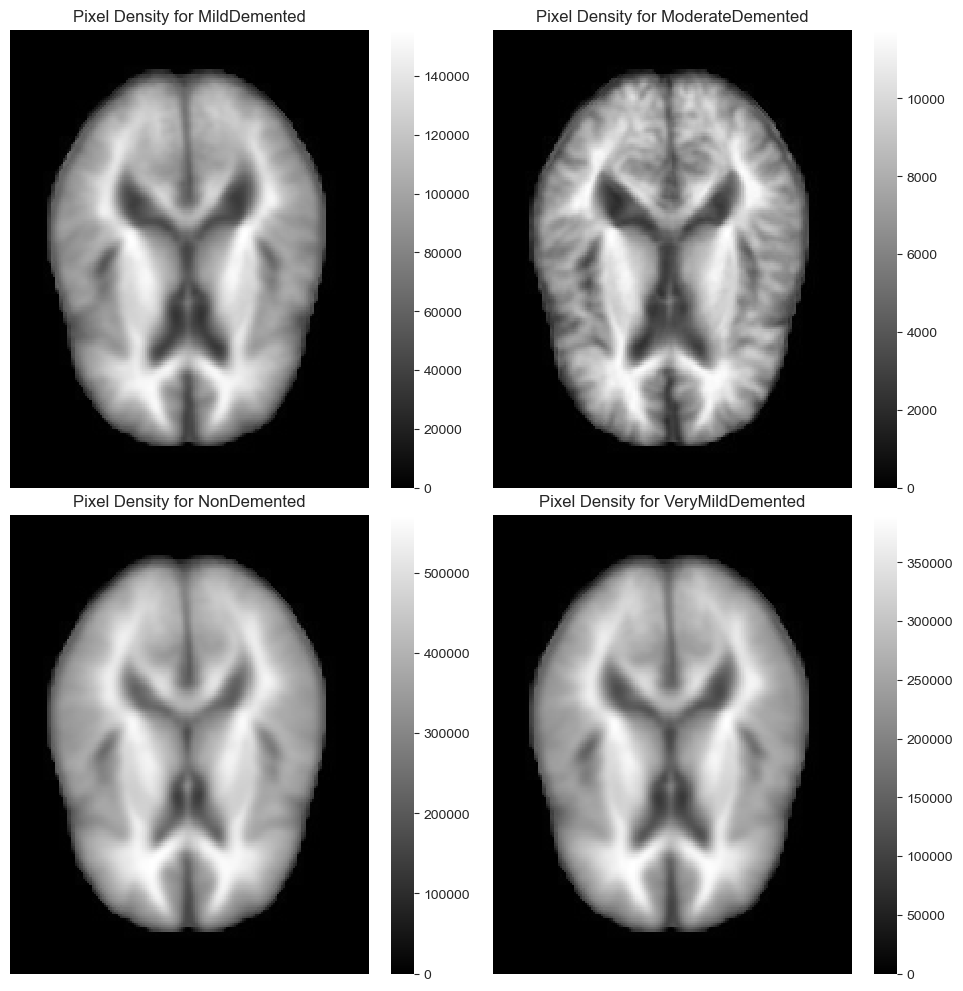

In [24]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10), sharey=True, sharex=True)
fig.tight_layout()

for i in range(len(classes)):
    ax = axes[i//2, i%2]
    class_images = images[np.where(images_labels == i)]
    heatmap = np.sum(class_images, axis=0)
    sns.heatmap(heatmap, ax=ax, cmap='gray')
    ax.set_title(f'Pixel Density for {classes[i]}')
    ax.get_yaxis().set_visible(False)
    ax.get_xaxis().set_visible(False)

#### Drop all empty pixels to reduce dimensions

In [25]:
# get leftmost non empty pixel
non_empty_pixels = np.where(images > 0)[1:]

In [26]:
non_empty_pixels

(array([ 16,  16,  16, ..., 191, 191, 191], dtype=int64),
 array([ 56,  64,  65, ..., 112, 115, 116], dtype=int64))

In [27]:
uppermost_pixel = np.min(non_empty_pixels[0])
bottommost_pixel = np.max(non_empty_pixels[0])
leftmost_pixel = np.min(non_empty_pixels[1])
rightmost_pixel = np.max(non_empty_pixels[1])

In [28]:
# top left
leftmost_pixel, uppermost_pixel

(16, 16)

In [29]:
# bottom right
rightmost_pixel, bottommost_pixel

(159, 191)

In [30]:
# dropping
images = images[:, uppermost_pixel:bottommost_pixel+1, leftmost_pixel:rightmost_pixel+1]

In [31]:
images.shape

(5121, 176, 144)

In [32]:
df = pd.DataFrame(images.reshape(images.shape[0], -1))

In [33]:
df.shape

(5121, 25344)

In [34]:
# number of reduced dimensions
208 * 176 - 25344

11264

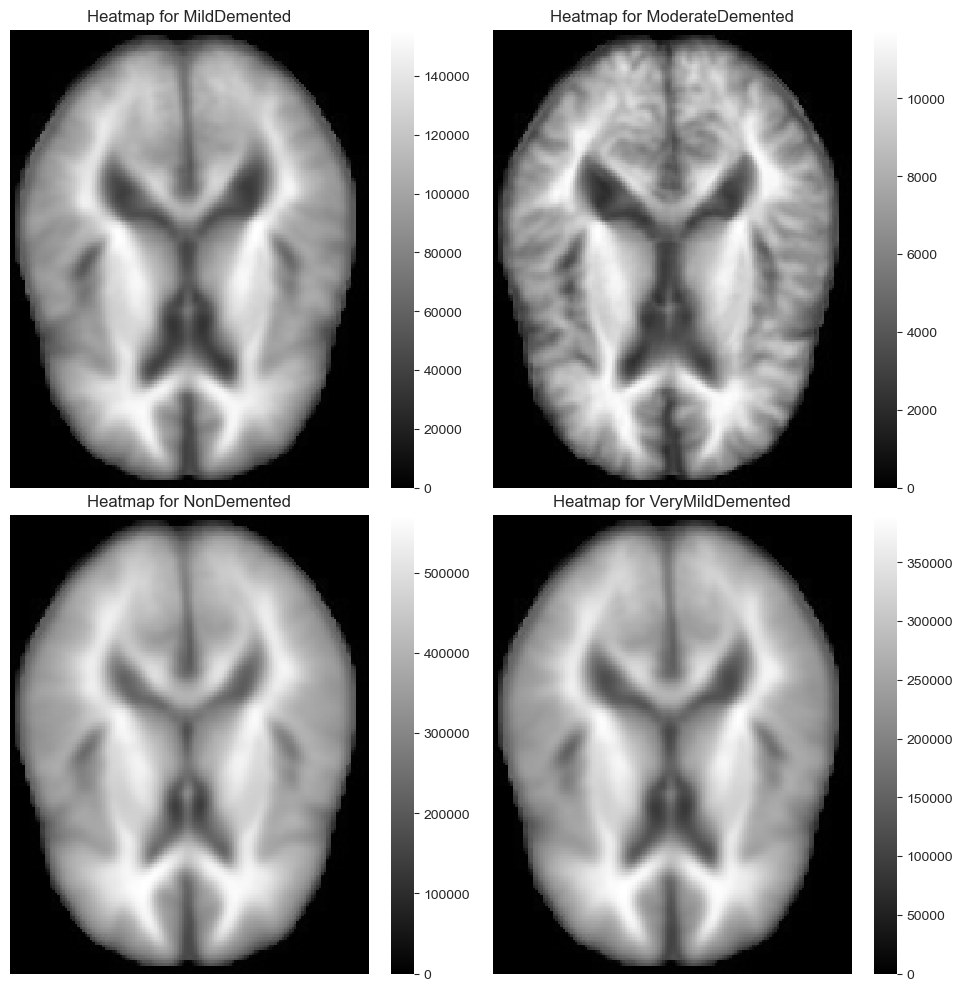

In [35]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10), sharey=True, sharex=True)
fig.tight_layout()

for i in range(len(classes)):
    ax = axes[i//2, i%2]
    class_images = images[np.where(images_labels == i)]
    heatmap = np.sum(class_images, axis=0)
    sns.heatmap(heatmap, ax=ax, cmap='gray')
    ax.set_title(f'Heatmap for {classes[i]}')
    ax.get_yaxis().set_visible(False)
    ax.get_xaxis().set_visible(False)

#### NOT normalizing the images as the decoding process is less successful when dealing with a small range of numbers

In [36]:
# images = images / 255.0

#### Showing distribution of several pixels

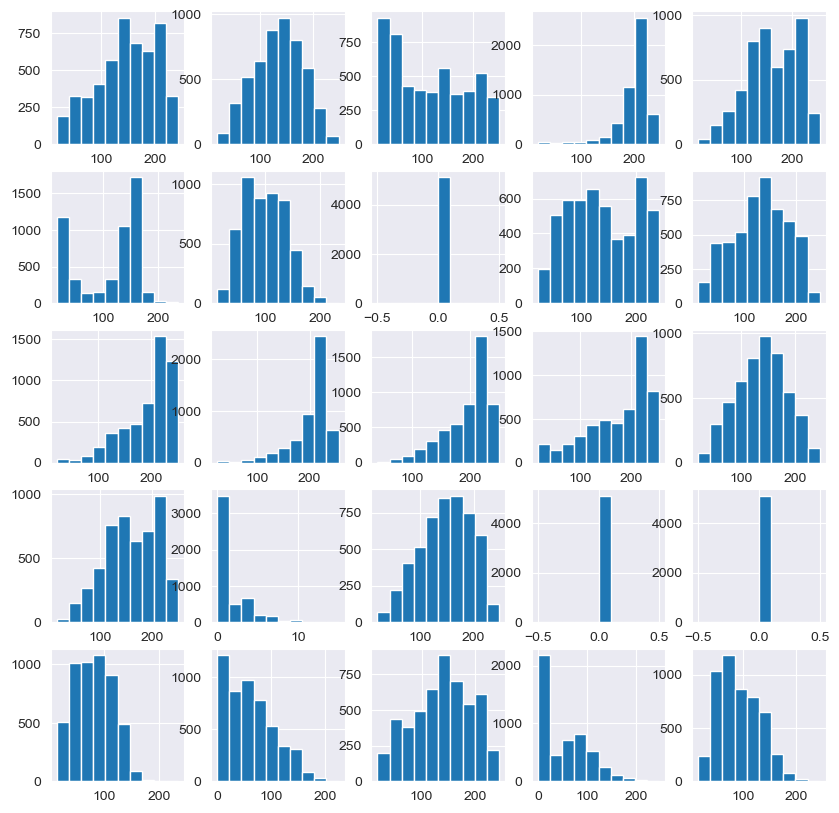

In [37]:
fig, axes = plt.subplots(5, 5, figsize=(10, 10))

random_pixels = np.random.default_rng().choice(176 * 144, size=25, replace=False)

for i in range(25):
    ax = axes[i // 5, i % 5]
    ax.hist(images[:, random_pixels[i]//176, random_pixels[i]%144])

### Filters

In [38]:
import scipy as sp

In [39]:
def plot_transformed_and_original(transformed_images):
    # plot
    fig = plt.figure(constrained_layout=True, figsize=(18, 10))
    subfigs = fig.subfigures(2, 2)

    for class_idx, subfig in enumerate(subfigs.flat):
        subfig.suptitle(classes[class_idx])
        axes = subfig.subplots(1, 2)

        blurred_images = transformed_images[np.where(images_labels == class_idx)]
        blurred_heatmap = np.sum(blurred_images, axis=0)
        sns.heatmap(blurred_heatmap, ax=axes[0], cmap='gray')
        axes[0].set_title('Blurred')
        axes[0].get_yaxis().set_visible(False)
        axes[0].get_xaxis().set_visible(False)

        original_images = images[np.where(images_labels == class_idx)]
        original_heatmap = np.sum(original_images, axis=0)
        sns.heatmap(original_heatmap, ax=axes[1], cmap='gray')
        axes[1].set_title('Original')
        axes[1].get_yaxis().set_visible(False)
        axes[1].get_xaxis().set_visible(False)

In [40]:
def apply_filter(images, filter_func, **kwargs):
    filtered_images = filter_func(images, **kwargs)
    plot_transformed_and_original(filtered_images)

#### Applying median filter with a kernel size of 3x3

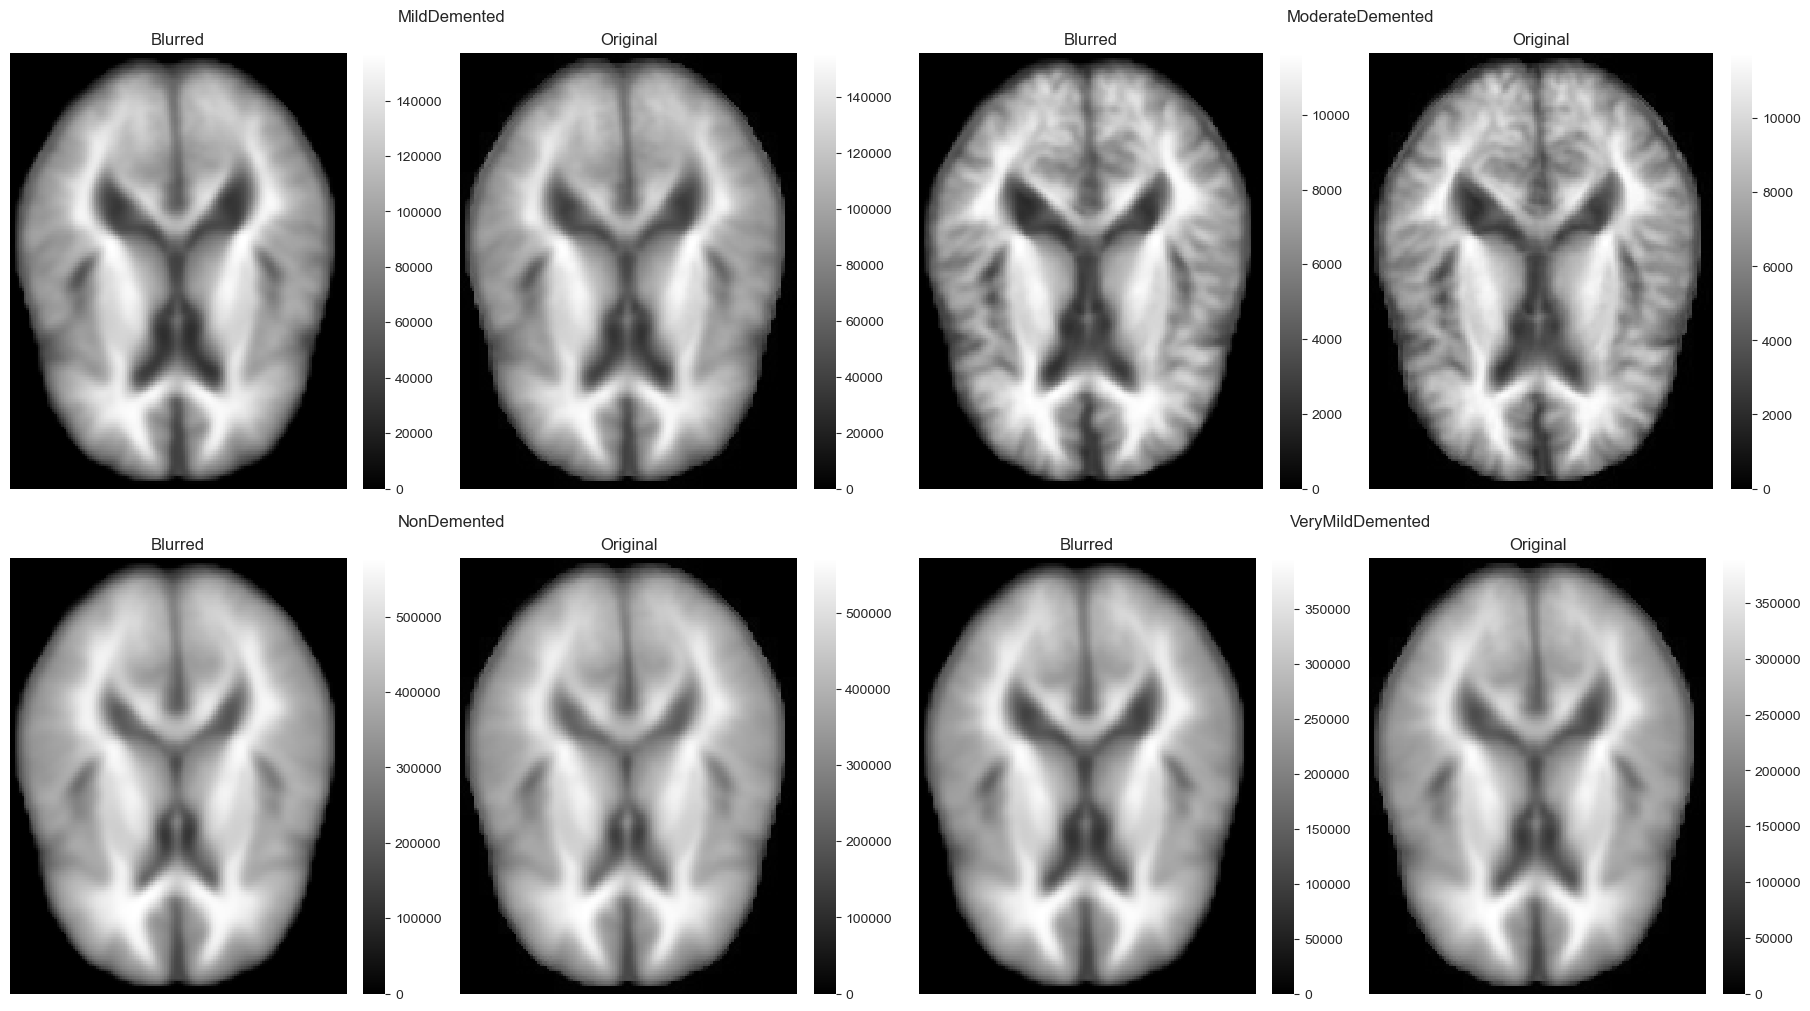

In [41]:
apply_filter(images, sp.ndimage.median_filter, size=3)

#### Applying max filter with same kernel

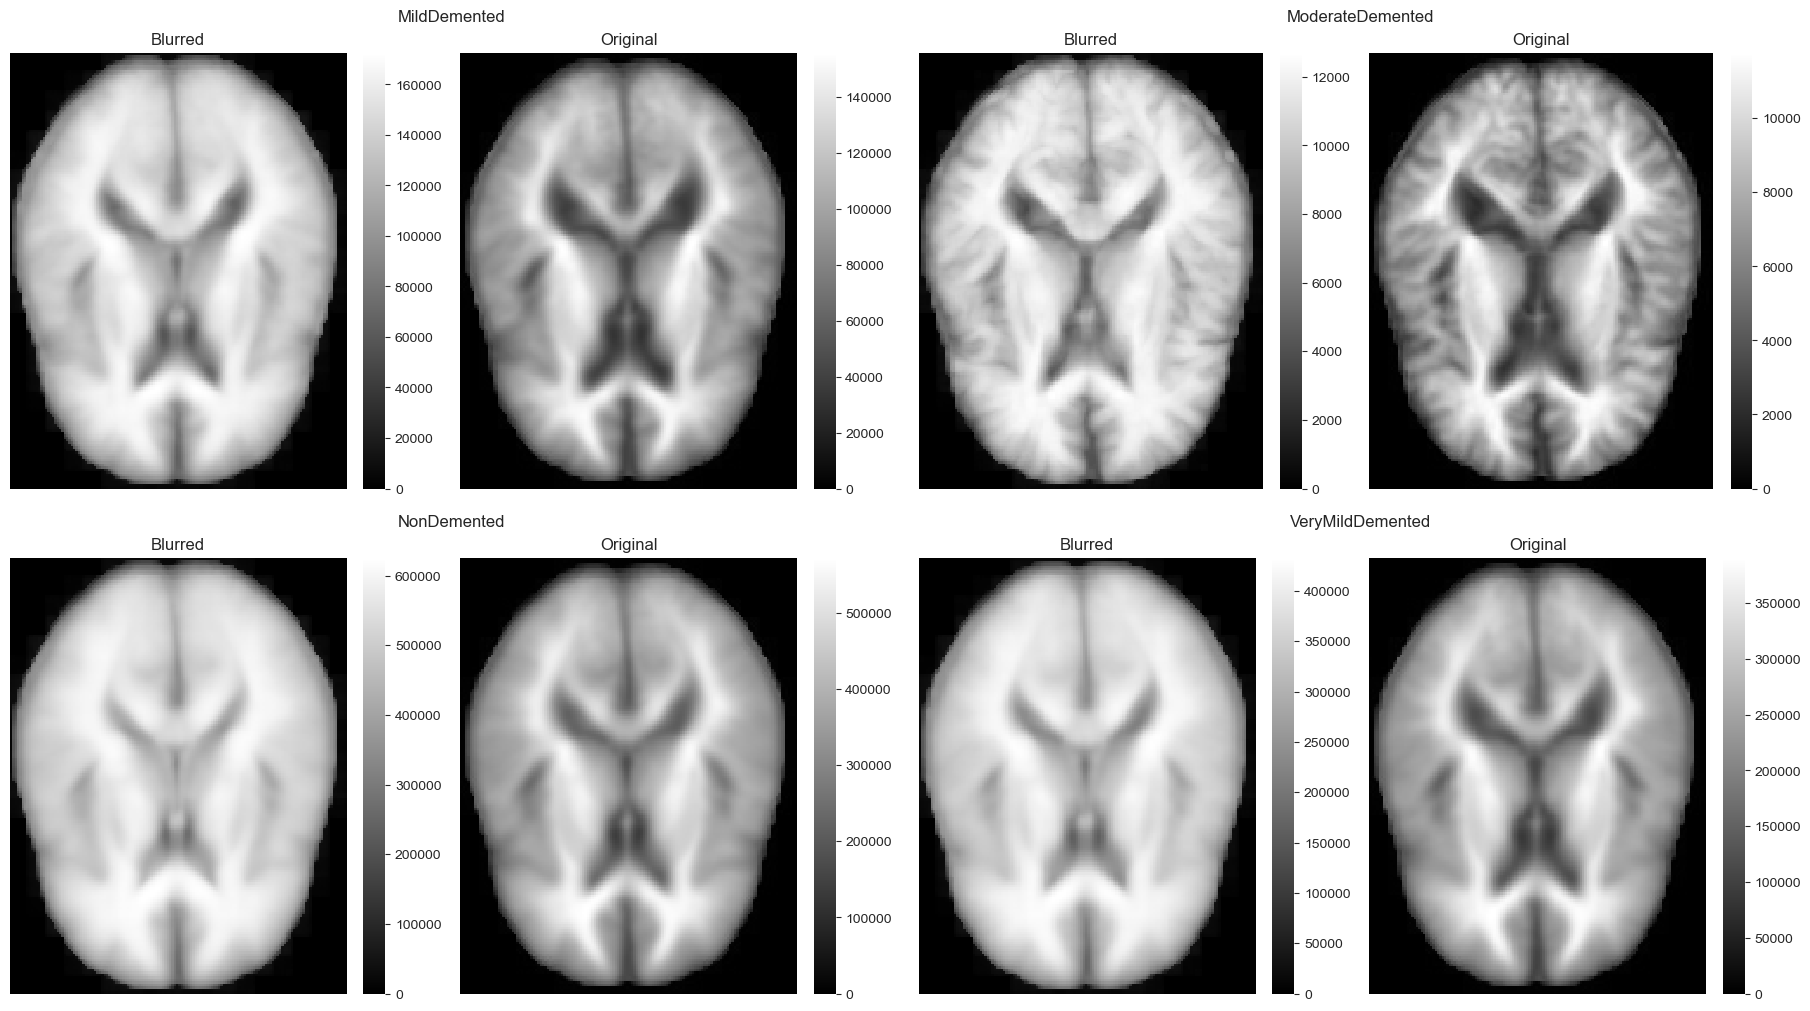

In [42]:
apply_filter(images, sp.ndimage.maximum_filter, size=3)

#### Minimum filter

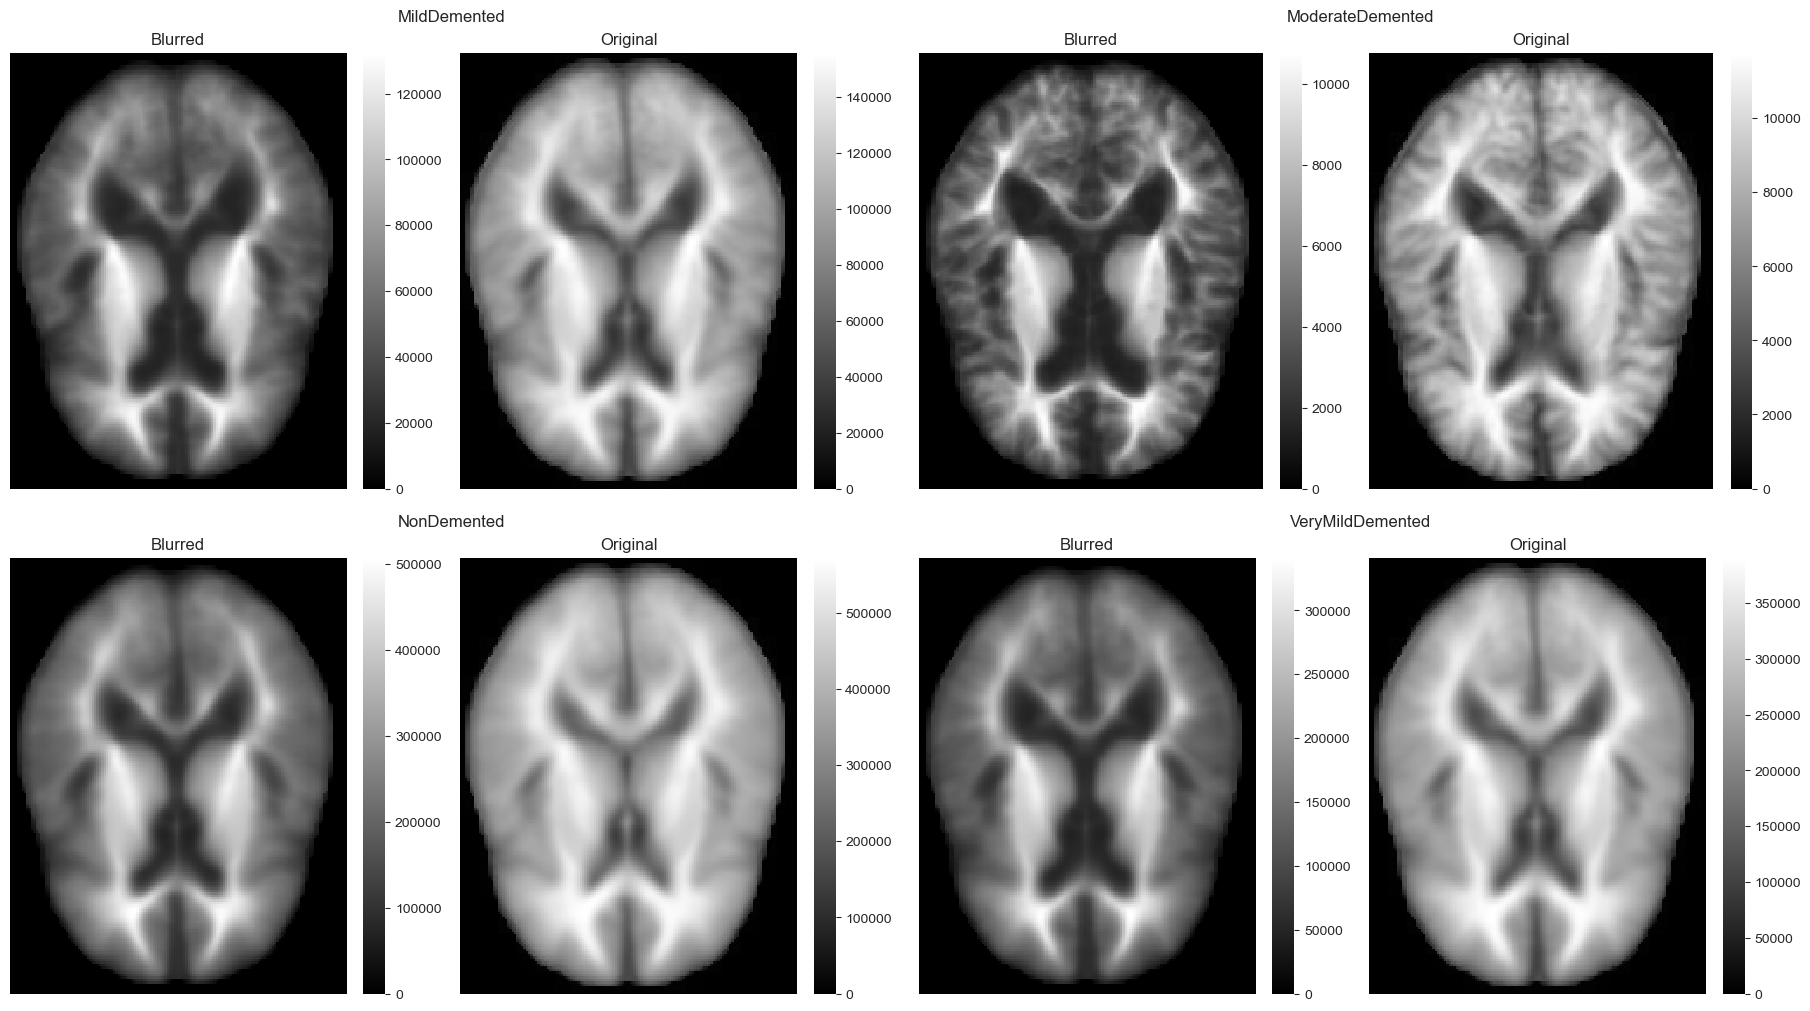

In [43]:
apply_filter(images, sp.ndimage.minimum_filter, size=3)

#### Sobel filter

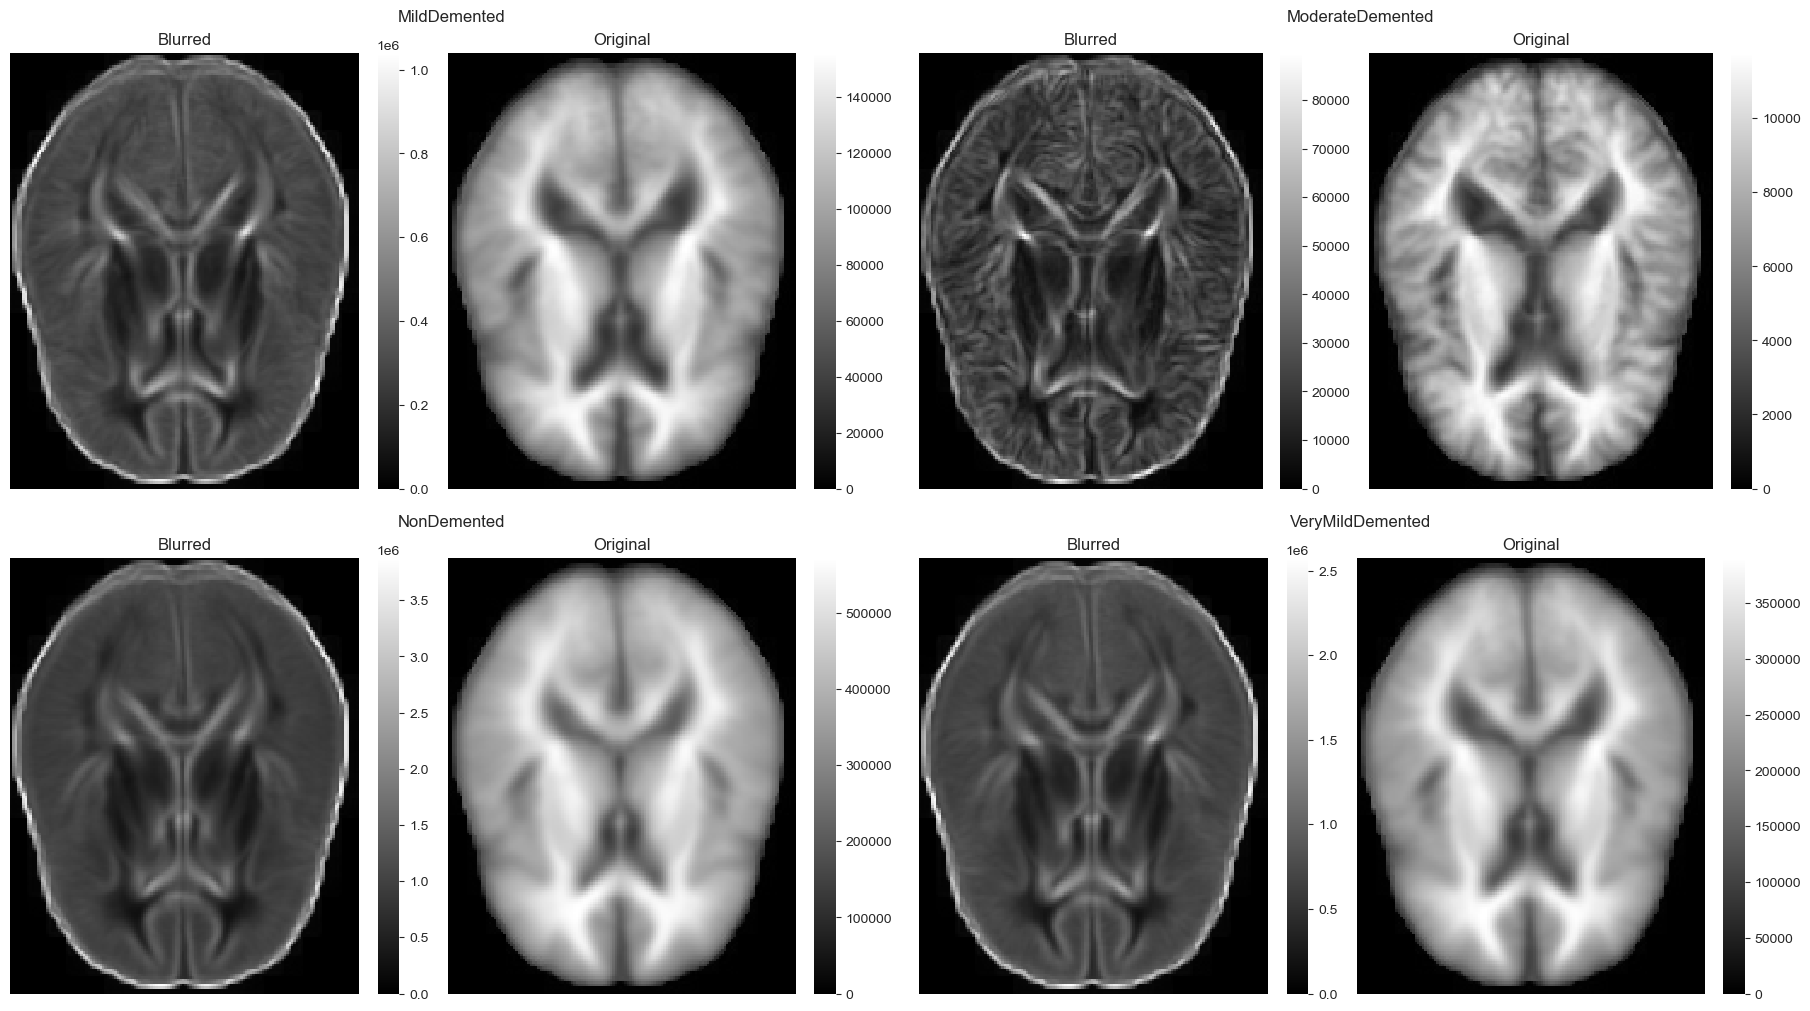

In [44]:
sobel_images_x = sp.ndimage.sobel(images, axis=1)
sobel_images_y = sp.ndimage.sobel(images, axis=2)
sobel_images = np.sqrt(sobel_images_x ** 2 + sobel_images_y ** 2)

plot_transformed_and_original(sobel_images)

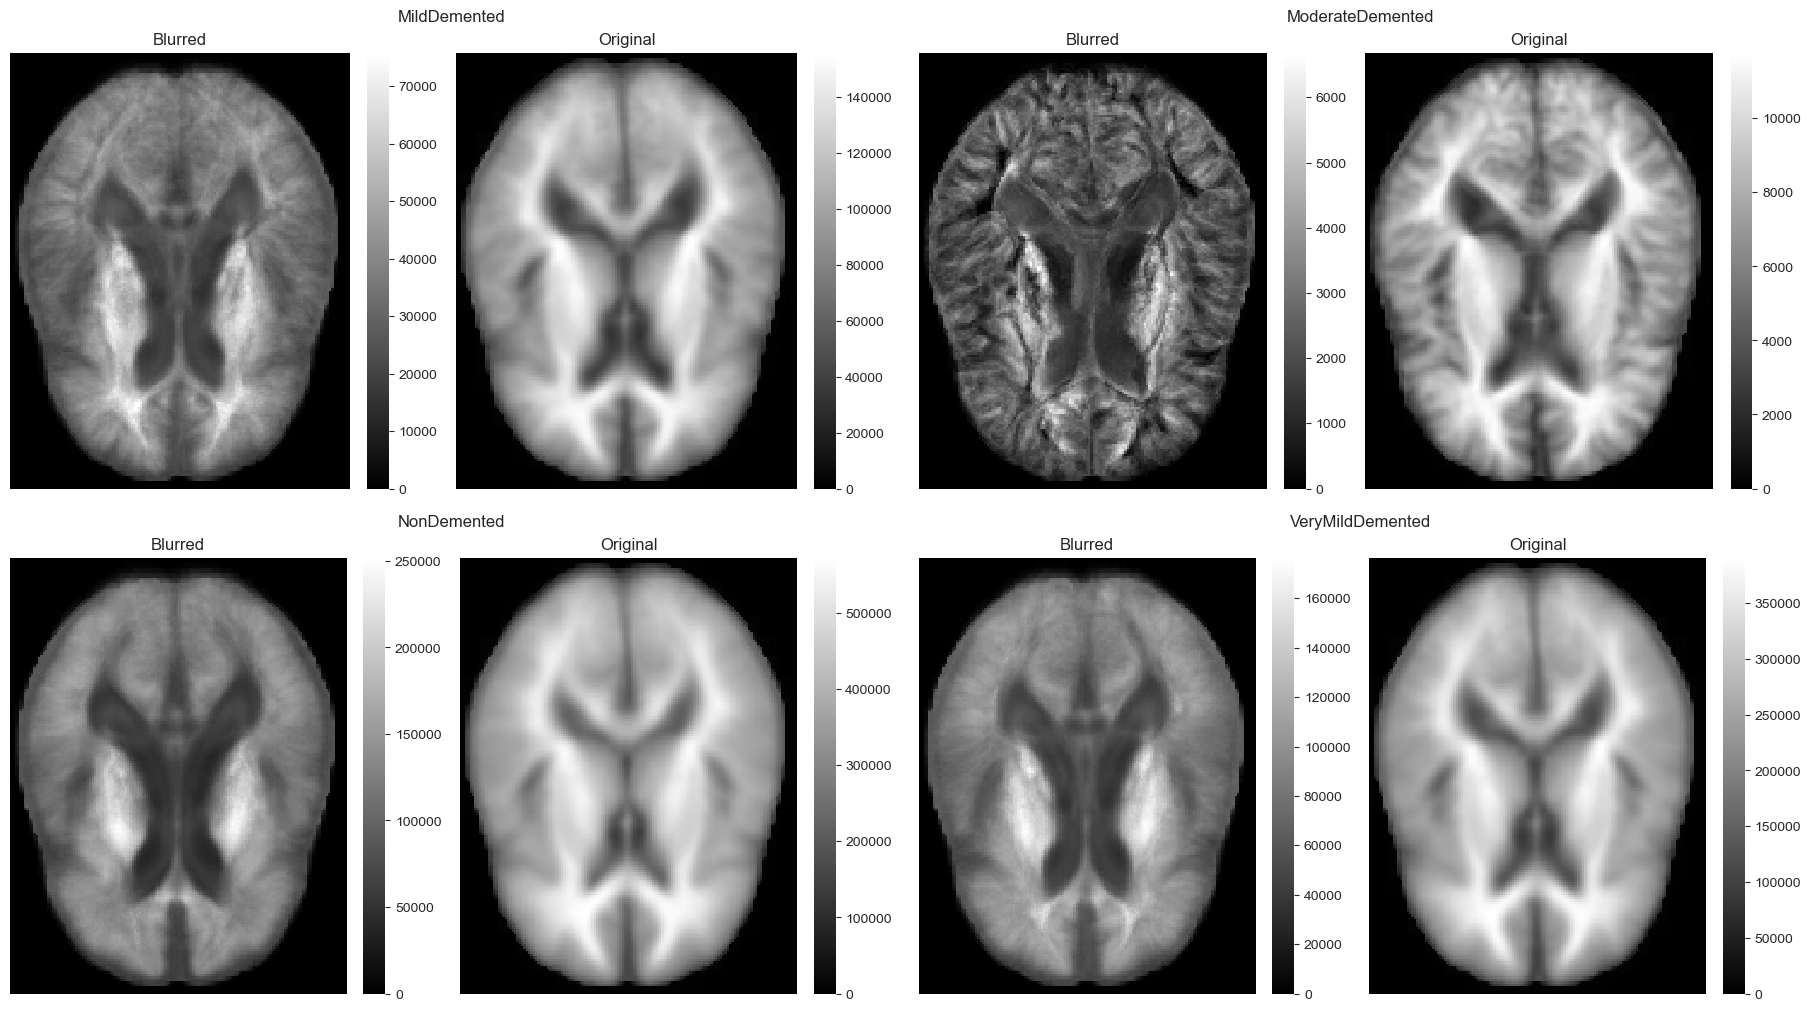

In [45]:
# turning off pixels smaller than their image's mean
greater_than_mean = np.where(images > images.mean(axis=0), 0, images)
plot_transformed_and_original(greater_than_mean)

### Data Augmentation

#### Training a variational autoencoder for augmenting randomized corrupted data to create new samples

In [46]:
import torch
from torch import nn

In [47]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

#### Preparing data for PyTorch

In [48]:
class AlzheimerDataset(torch.utils.data.Dataset):
    def __init__(self, np_images, np_labels, transform=None, target_transform=None):
        # self.X = torch.from_numpy(np_images).to(torch.float32)
        self.X = torch.from_numpy(np_images).to(torch.float32).unsqueeze(dim=1) # adding the single channel
        # self.y = torch.from_numpy(np_labels).to(torch.float32)
        self.y = torch.from_numpy(np_labels)
        
        self.transform = transform
        self.target_transform = target_transform
        
        self.len = len(self.X)
        
    def __len__(self):
        return self.len
    
    def __getitem__(self, idx):
        images = self.X[idx]
        labels = self.y[idx]
        if self.transform:
            images = self.transform(images)
        if self.target_transform:
            labels = self.target_transform(labels)
        
        return images, labels

#### Defining encoder and decoder

In [49]:
class ConvEncoder(nn.Module):
    def __init__(self, in_channels, encoded_dim, initial_out_channels=3, device='cpu'):
        super().__init__()
        
        self.device = device
        
        # non parameterized functionality
        self.relu = nn.ReLU()
        self.flatten = nn.Flatten()
        
        out_channels = initial_out_channels
        
        # input.shape = in_channels x 176 x 144
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=(5, 5),
                               stride=(2, 2), padding=(3, 3), bias=False)
        # height = (176 + 2*3 - 1*(5-1) - 1)/2 + 1 = 89
        # width = (144 + 2*3 - 1*(5-1) - 1)/2 + 1 = 73
        # output shape = (batch x out_channels x 89 x 73)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.max_indices = None
        self.maxpool = nn.MaxPool2d(kernel_size=(3, 3), stride=(2, 2), 
                                    padding=(1, 1), ceil_mode=False, return_indices=True)
        # height = ((89 + 2*1 - 1*(3-1) - 1)/2 + 1 = 45
        # width = ((73 + 2*1 - 1*(3-1) - 1)/2 + 1 = 37
        
        # first residual block
        self.block0 = nn.Sequential(
            # bias is false as we have a bias in the BN layer
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, stride=1, bias=False),
            nn.BatchNorm2d(out_channels),
            self.relu,
#             nn.Dropout2d(0.25),
            nn.MaxPool2d(kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(out_channels),
            self.relu
        )
        
        out_channels *= 2
        
        # down sampling
        self.down_sample0 = nn.Sequential(
            nn.Conv2d(out_channels // 2, out_channels, 3, padding=1, stride=2, bias=False),
            nn.BatchNorm2d(out_channels),
            self.relu,
#             nn.Dropout2d(0.25),
        )
        
        self.block1 = nn.Sequential(
            # bias is false as we have a bias in the BN layer
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, stride=1, bias=False),
            nn.BatchNorm2d(out_channels),
            self.relu,
#             nn.Dropout2d(0.25),
            nn.MaxPool2d(kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(out_channels),
            self.relu,
        )
        
        out_channels *= 2
        
        self.down_sample1 = nn.Sequential(
            nn.Conv2d(out_channels // 2, out_channels, 3, padding=1, stride=2, bias=False),
            nn.BatchNorm2d(out_channels),
            self.relu,
#             nn.Dropout2d(0.25)
        )
        
        self.block2 = nn.Sequential(
            # bias is false as we have a bias in the BN layer
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, stride=1, bias=False),
            nn.BatchNorm2d(out_channels),
            self.relu,
#             nn.Dropout2d(0.25),
            nn.MaxPool2d(kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(out_channels),
            self.relu,
        )
        
        out_channels *= 2
        
        self.down_sample2 = nn.Sequential(
            nn.Conv2d(out_channels // 2, out_channels, 3, padding=1, stride=2, bias=False),
            nn.BatchNorm2d(out_channels),
            self.relu,self.relu,
#             nn.Dropout2d(0.25)
        )
        
        # self.linear = nn.Linear(in_features=1440, out_features=encoded_dim, bias=True)
        
        # 240 * initial_out_channels
        self.encoded_mean = nn.Linear(240 * initial_out_channels, out_features=encoded_dim, bias=True)
        self.encoded_log_variance = nn.Linear(240 * initial_out_channels, out_features=encoded_dim, bias=True)
        
        self.final_out_channels = out_channels
        
            
    def forward(self, X):
        X0 = self.conv1(X)
        X0 = self.bn1(X0)
        X0 = self.relu(X0)
        X0, self.max_indices = self.maxpool(X0)
        
        # residual block
        Y0_ = X0 + self.block0(X0)
        Y0 = self.down_sample0(Y0_)
        Y0 = self.relu(Y0)
        
        # print(f'Y0: {Y0.shape}')
        
        Y1_ = Y0 + self.block1(Y0)
        Y1 = self.down_sample1(Y1_)
        Y1 = self.relu(Y1)

        # print(f'Y1: {Y1.shape}')
        
        Y2_ = Y1 + self.block2(Y1)
        Y2 = self.down_sample2(Y2_)
        Y2 = self.relu(Y2)
        
        # print(f'Y2: {Y2.shape}')
        Y = self.flatten(Y2)
        # print(f'Y: {Y.shape}')
        # Y = self.linear(Y.squeeze())
        # 
        # return Y
        
        # TODO: modify to match a custom distribution
        encoded_mean = self.encoded_mean(Y)
        encoded_log_var = self.encoded_log_variance(Y)
        epsilon = torch.randn_like(encoded_mean).to(device=self.device, dtype=torch.float32)
        encoded = encoded_mean + epsilon * torch.exp(encoded_log_var/2).to(device=self.device, dtype=torch.float32)
        
        return encoded, encoded_mean, encoded_log_var

In [50]:
class ConvDecoder(nn.Module):
    def __init__(self, encoded_dim, initial_out_channels, encoder_initial_out_channels):
        super().__init__()
        
        self.initial_out_channels = initial_out_channels
        out_channels = initial_out_channels
        
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.zero_padding = nn.ZeroPad2d(2)
        
        # 240 * encoder_initial_out_channels
        self.linear = nn.Linear(in_features=encoded_dim, out_features=240 * encoder_initial_out_channels, bias=True)
        
        # reshape to image shape before passing through this block
        self.up_sample0 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=out_channels, out_channels=out_channels // 2,
                               kernel_size=3, padding=1, stride=2, bias=False),
            nn.BatchNorm2d(out_channels // 2),
            nn.ReLU(),
#             nn.Dropout2d(0.25),
        )

        out_channels = out_channels // 2

        self.block0 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=out_channels, out_channels=out_channels,
                   kernel_size=3, padding=1, stride=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
#             nn.Dropout2d(0.25),
            nn.ConvTranspose2d(in_channels=out_channels, out_channels=out_channels,
                               kernel_size=3, padding=1, stride=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )
        
        self.up_sample1 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=out_channels, out_channels=out_channels // 2,
                               kernel_size=3, padding=1, stride=2, bias=False),
            nn.BatchNorm2d(out_channels // 2),
            nn.ReLU(),
#             nn.Dropout2d(0.25),
        )
        
        out_channels = out_channels // 2    
        
        self.block1 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=out_channels, out_channels=out_channels,
                   kernel_size=3, padding=1, stride=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
#             nn.Dropout2d(0.25),
            nn.ConvTranspose2d(in_channels=out_channels, out_channels=out_channels,
                               kernel_size=3, padding=1, stride=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )
        
        self.up_sample2 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=out_channels, out_channels=out_channels // 2,
                               kernel_size=3, padding=1, stride=2, bias=False),
            nn.BatchNorm2d(out_channels // 2),
            nn.ReLU(),
#             nn.Dropout2d(0.25),
        )
        
        out_channels = out_channels // 2
        
        self.block2 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=out_channels, out_channels=out_channels,
                   kernel_size=3, padding=1, stride=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
#             nn.Dropout2d(0.25),
            nn.ConvTranspose2d(in_channels=out_channels, out_channels=out_channels,
                               kernel_size=3, padding=1, stride=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )
        
        self.max_indices = None
        self.max_unpool = nn.MaxUnpool2d(kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        self.conv_transpose1 = nn.ConvTranspose2d(out_channels, 1, kernel_size=(5, 5),
                                                  stride=(2, 2), padding=(2, 2), bias=False)
        self.bn1 = nn.BatchNorm2d(1)
        
        
    def set_max_indices(self, max_indices):
        self.max_indices = max_indices

    def forward(self, X):
        # print(X.shape)
        X0 = self.linear(X)
        
        # print(X0.shape)
        # reshaping to (batch, channels, pixels) shape
        X0 = X0.reshape(-1, self.initial_out_channels, 6, 5)
        # X0 = X0.reshape(-1, self.initial_out_channels, 12, 10)
        X0 = self.relu(X0)
        
        # print(f'X0: {X0.shape}')
        
        Y0_ = self.up_sample0(X0)
        Y0 = Y0_ + self.block0(Y0_)
        Y0 = self.relu(Y0)
        
        # print(f'Y0: {Y0.shape}')
        
        Y1_ = self.up_sample1(Y0)
        Y1 = Y1_ + self.block1(Y1_)
        Y1 = self.relu(Y1)
        
        # print(f'Y1: {Y1.shape}')
        
        Y2_ = self.up_sample2(Y1)
        Y2 = Y2_ + self.block2(Y2_)
        Y2 = self.relu(Y2)
        # print(Y2.shape)
        # Y = Y2
        Y2 = self.zero_padding(Y2)
        # print(Y2.shape)
        # if self.training:
        Y = self.max_unpool(Y2, self.max_indices)
        num_pixels_to_cut = 1
        # else:
        # Y = self.upsample(Y2)
        # Y = self.conv(Y)
        # Y = self.bn(Y)
        # num_pixels_to_cut = 3
        
        # Y = self.conv()
        # print(Y.shape)
        Y = self.conv_transpose1(Y)
        Y = self.bn1(Y)
        Y = self.relu(Y)
        # remove last row and column in the image
        Y = Y[..., :-num_pixels_to_cut, :-num_pixels_to_cut]
        
        # print(Y.shape)
        # use sigmoid only if pixel values are in [0, 1] range
        # Y = self.sigmoid(Y)
        
        return Y

#### KL Divergence loss function to learn the mean and standard deviation of the latent space's distribution

In [51]:
def kl_divergence_loss(mean, log_var):
    kl_sum = torch.sum(1 + log_var - mean**2 - torch.exp(log_var), dim=1)
    return -0.5 * kl_sum.mean(dim=0)

In [52]:
class AutoEncoder(nn.Module):
    def __init__(self, in_channels, encoded_dim, initial_out_channels):
        super().__init__()
        # latent space is encoded_dim dimensions
        self.encoder = ConvEncoder(in_channels=in_channels, encoded_dim=encoded_dim,
                                   initial_out_channels=initial_out_channels, device=device)
        self.decoder = ConvDecoder(encoded_dim=encoded_dim,
                                   initial_out_channels=self.encoder.final_out_channels,
                                   encoder_initial_out_channels=initial_out_channels)

    def forward(self, X):
        encoded, encoded_mean, encoded_log_var = self.encoder(X)
        # encoded = self.encoder(X)
        self.decoder.set_max_indices(self.encoder.max_indices)
        decoded = self.decoder(encoded)
        
        # return decoded
        return encoded, encoded_mean, encoded_log_var, decoded

In [53]:
alzheimer_dataset = AlzheimerDataset(images, images_labels)

In [54]:
# using tensorboard for displaying training progress and metrices in real time
from torch.utils.tensorboard import SummaryWriter

In [78]:
def train_epoch(model, optimizer, loss, regularization_lambda, dataloader, dataset, overall_losses, kl_divergence_losses, mse_losses, epoch, scheduler=None):
    for batch_idx, (batch_X, _) in enumerate(dataloader):
        batch_X = batch_X.to(device)
        
        optimizer.zero_grad()
        
        batch_encoded_output, batch_encoded_mean, batch_encoded_log_var, batch_decoded_output = model(batch_X)
        # batch_decoded_output = autoencoder(batch_X)
    
        batch_mse_loss = loss(batch_decoded_output, batch_X)
        # batch_loss = batch_mse_loss
        batch_kl_divergence_loss = regularization_lambda * kl_divergence_loss(batch_encoded_mean, batch_encoded_log_var)
        batch_loss = batch_mse_loss + batch_kl_divergence_loss
    
        batch_loss.backward()
        optimizer.step()
    
    with torch.no_grad():
        model.eval()
        encoded_output, encoded_mean, encoded_log_var, decoded_output = model(dataset.X.to(device))
        # decoded_output = model(dataset.X.to(device))
        loss_value = loss(decoded_output, dataset.X.to(device))
        # output_loss = loss_value
        kl_divergence_loss_value = regularization_lambda * kl_divergence_loss(encoded_mean, encoded_log_var)
        output_loss = loss_value + kl_divergence_loss_value

        overall_losses[epoch] = output_loss.item()
        kl_divergence_losses[epoch] = kl_divergence_loss_value.item()
        mse_losses[epoch] = loss_value.item()

        # update learning rate after each epoch to have equal effect for every batch
    if scheduler is not None and epoch < 75:
        scheduler.step()
        
    

In [79]:
def train(trial, model, optimizer, loss, epochs, regularization_lambda, dataloader, dataset, scheduler=None, plot=True):
    # writer = SummaryWriter(log_dir='./logs')
    
    overall_losses = torch.zeros(epochs)
    kl_divergence_losses = torch.zeros(epochs)
    mse_losses = torch.zeros(epochs)
    
    for epoch in tqdm(range(epochs)):
        model.train()
        
        train_epoch(
            model=model,
            optimizer=optimizer, 
            loss=loss,
            epoch=epoch,
            regularization_lambda=regularization_lambda,
            dataloader=dataloader,
            dataset=dataset,
            overall_losses=overall_losses,
            kl_divergence_losses=kl_divergence_losses,
            mse_losses=mse_losses,
            scheduler=scheduler
        )
        
        if trial is not None:
            trial.report(overall_losses.numpy()[epoch], epoch)

            if trial.should_prune():
                raise optuna.TrialPruned()

    if plot:
        fig, axes = plt.subplots(1, 3, figsize=(16, 6))

        axes[0].plot(overall_losses.cpu())
        axes[0].set_title('Overall Loss')
        
        axes[1].plot(kl_divergence_losses.cpu())
        axes[1].set_title('KL Divergence Loss')
        
        axes[2].plot(mse_losses.cpu())
        axes[2].set_title('MSE Loss')
        
    # writer.flush()
    
    return overall_losses, kl_divergence_losses, mse_losses

In [80]:
import optuna

In [81]:
def objective(trial):
    encoded_dim = trial.suggest_int('encoded_dim', 2, 64*64)
    initial_out_channels = trial.suggest_int('initial_out_channels', 2, 8)
    autoencoder = AutoEncoder(in_channels=1, encoded_dim=encoded_dim, initial_out_channels=initial_out_channels).to(device)
    
    lr = trial.suggest_float('lr', 1e-3, 1e-2, log=True)
    weight_decay = trial.suggest_float('weight_decay', 0.1, 0.4, log=True)
    momentum = trial.suggest_float('momentum', 0, 0.5)
    dampening = trial.suggest_float('dampening', 0, 0.5)
    optimizer = torch.optim.SGD(autoencoder.parameters(), lr=lr, weight_decay=weight_decay, momentum=momentum, dampening=dampening)
    
    scheduler_gamma = trial.suggest_float('scheduler_gamma', 0.8, 0.999)
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=scheduler_gamma)
    
    kl_divergence_lambda = trial.suggest_float('kl_divergence_lambda', 0.5, 5)
    
    epochs = trial.suggest_int('epochs', 50, 100)
    batch_size = trial.suggest_int('batch_size', 32, 256)

    mse = nn.MSELoss()

    dataloader = torch.utils.data.DataLoader(alzheimer_dataset, batch_size=batch_size, shuffle=True)

    overall_losses, kl_divergence_losses, mse_losses = train(
        model=autoencoder,
        optimizer=optimizer,
        loss=mse,
        epochs=epochs,
        regularization_lambda=kl_divergence_lambda,
        dataloader=dataloader,
        dataset=alzheimer_dataset,
        scheduler=scheduler,
        plot=False,
        trial=trial
    )
    
    return overall_losses.numpy()[-1]

In [110]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=25, timeout=120000)

[I 2024-10-10 08:52:03,204] A new study created in memory with name: no-name-fbef6287-4d3c-4fd7-b3a2-9a5442cb8b82
100%|██████████| 59/59 [00:37<00:00,  1.59it/s]
[I 2024-10-10 08:52:40,265] Trial 0 finished with value: 4715.63818359375 and parameters: {'encoded_dim': 1211, 'initial_out_channels': 2, 'lr': 0.0035044053367941476, 'weight_decay': 0.28178965668952305, 'momentum': 0.2372912925699206, 'dampening': 0.47908148764801867, 'scheduler_gamma': 0.8698414518284919, 'kl_divergence_lambda': 1.060106560216218, 'epochs': 59, 'batch_size': 98}. Best is trial 0 with value: 4715.63818359375.
100%|██████████| 71/71 [00:59<00:00,  1.19it/s]
[I 2024-10-10 08:53:39,992] Trial 1 finished with value: 1732.0753173828125 and parameters: {'encoded_dim': 448, 'initial_out_channels': 8, 'lr': 0.008383656159910945, 'weight_decay': 0.26727671352247495, 'momentum': 0.45586867494758454, 'dampening': 0.08360069825538152, 'scheduler_gamma': 0.931428536510001, 'kl_divergence_lambda': 3.1025392118256323, 'epo

In [111]:
pruned_trials = study.get_trials(deepcopy=False, states=[optuna.trial.TrialState.PRUNED])
completed_trials = study.get_trials(deepcopy=False, states=[optuna.trial.TrialState.COMPLETE])

In [112]:
study.best_trial

FrozenTrial(number=14, state=1, values=[835.6607055664062], datetime_start=datetime.datetime(2024, 10, 10, 9, 1, 35, 83674), datetime_complete=datetime.datetime(2024, 10, 10, 9, 2, 51, 804779), params={'encoded_dim': 2942, 'initial_out_channels': 8, 'lr': 0.005183212977996399, 'weight_decay': 0.13134430224387, 'momentum': 0.2638754463591214, 'dampening': 0.005483607192647268, 'scheduler_gamma': 0.9300005273714611, 'kl_divergence_lambda': 3.9423241757246994, 'epochs': 80, 'batch_size': 72}, user_attrs={}, system_attrs={}, intermediate_values={0: 2623.59912109375, 1: 2153.220458984375, 2: 2159.19287109375, 3: 1711.3695068359375, 4: 1637.2838134765625, 5: 1551.39208984375, 6: 1583.4842529296875, 7: 1128.6258544921875, 8: 1364.2794189453125, 9: 1020.374755859375, 10: 1126.3564453125, 11: 947.4092407226562, 12: 979.3445434570312, 13: 982.439697265625, 14: 1433.1104736328125, 15: 1180.905517578125, 16: 939.9784545898438, 17: 1035.0546875, 18: 1060.5963134765625, 19: 956.775146484375, 20: 104

In [114]:
study.best_trial.params

{'encoded_dim': 2942,
 'initial_out_channels': 8,
 'lr': 0.005183212977996399,
 'weight_decay': 0.13134430224387,
 'momentum': 0.2638754463591214,
 'dampening': 0.005483607192647268,
 'scheduler_gamma': 0.9300005273714611,
 'kl_divergence_lambda': 3.9423241757246994,
 'epochs': 80,
 'batch_size': 72}

In [115]:
encoded_dim = study.best_trial.params['encoded_dim']
initial_out_channels = study.best_trial.params['initial_out_channels']
autoencoder = AutoEncoder(in_channels=1, encoded_dim=encoded_dim, initial_out_channels=initial_out_channels).to(device)
encoder = autoencoder.encoder
decoder = autoencoder.decoder

In [116]:
sum(p.numel() for p in autoencoder.parameters())

17039598

In [117]:
# lr = 0.008
lr = study.best_trial.params['lr']
weight_decay = study.best_trial.params['weight_decay']
momentum = study.best_trial.params['momentum']
dampening = study.best_trial.params['dampening']
scheduler_gamma = study.best_trial.params['scheduler_gamma']
# optimizer = torch.optim.Adam(autoencoder.parameters(), lr=lr, betas=(0.5, 0.999), weight_decay=0.25)
# optimizer = torch.optim.SGD(autoencoder.parameters(), lr=lr, weight_decay=0.25, momentum=0, dampening=0.25)
optimizer = torch.optim.SGD(autoencoder.parameters(), lr=lr, weight_decay=weight_decay, momentum=momentum, dampening=dampening)
# scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=scheduler_gamma)
mse = nn.MSELoss()

# kl_divergence_lambda = 3
kl_divergence_lambda = study.best_trial.params['kl_divergence_lambda']

In [118]:
epochs = study.best_trial.params['epochs']
batch_size = study.best_trial.params['batch_size']

dataloader = torch.utils.data.DataLoader(alzheimer_dataset, batch_size=batch_size, shuffle=True)

100%|██████████| 80/80 [01:17<00:00,  1.04it/s]


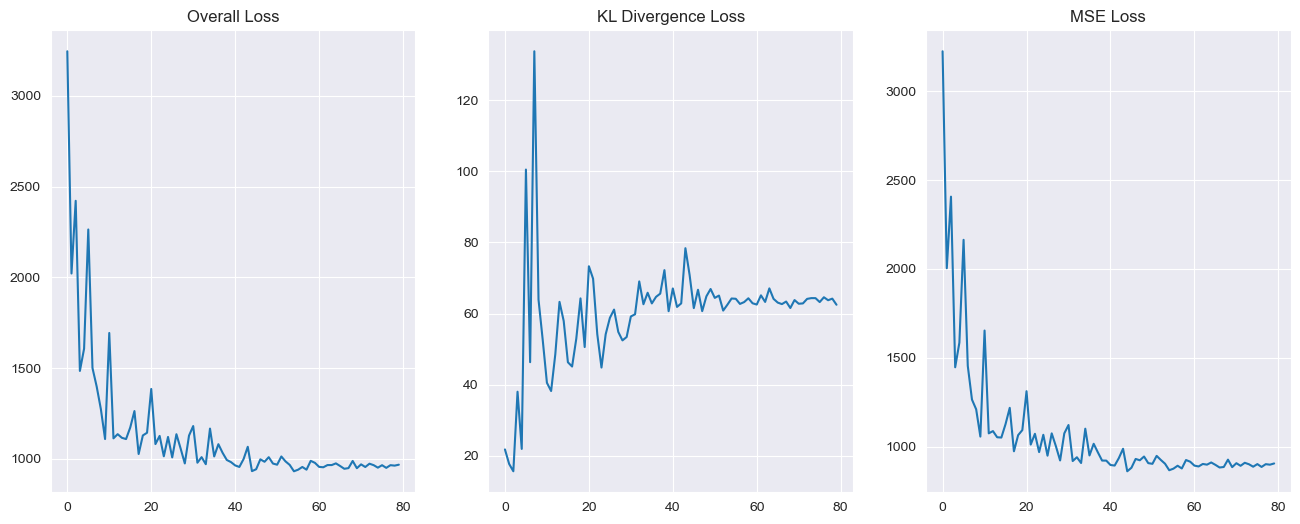

In [119]:
overall_losses, kl_divergence_losses, mse_losses = train(
    model=autoencoder,
    optimizer=optimizer,
    loss=mse,
    epochs=epochs,
    regularization_lambda=kl_divergence_lambda,
    dataloader=dataloader,
    dataset=alzheimer_dataset,
    scheduler=scheduler,
    plot=True,
    trial=None
)

In [120]:
image_to_generate = images[1]
# getting a generated image from the original
with torch.no_grad():
    # expanding the channel
    original_batched_image = np.expand_dims(image_to_generate, axis=0)
    # expanding batch
    original_batched_image = np.expand_dims(original_batched_image, axis=0)
    _, _, _, generated_image = autoencoder(torch.from_numpy(original_batched_image) \
                                  .to(device=device, dtype=torch.float32))
    
    generated_image = generated_image.flatten(start_dim=0, end_dim=2)
    print(generated_image.shape)

torch.Size([176, 144])


211.0

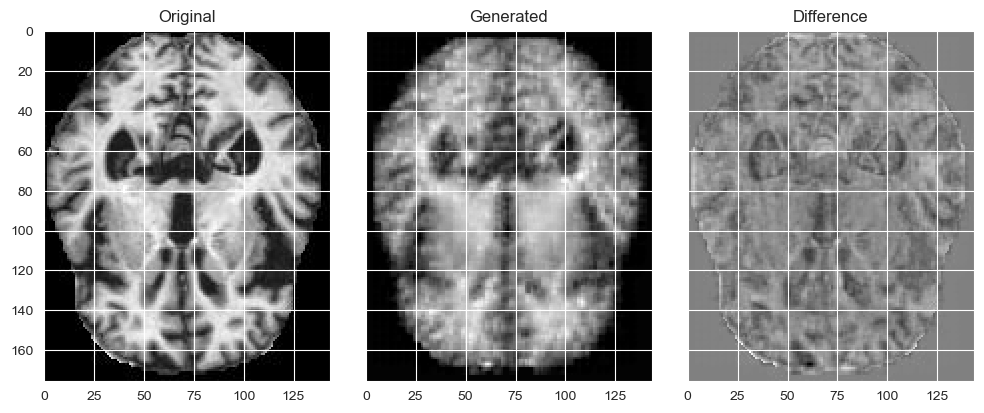

In [121]:
fig, axes = plt.subplots(1, 3, figsize=(10, 10), sharey=True, sharex=True)
fig.tight_layout()

axes[0].set_title('Original')
axes[0].imshow(image_to_generate, cmap='gray')
axes[1].set_title('Generated')
axes[1].imshow(generated_image.cpu(), cmap='gray')
axes[2].set_title('Difference')
axes[2].imshow(image_to_generate - generated_image.cpu().numpy(), cmap='gray')
(image_to_generate - generated_image.cpu().numpy()).max()

In [122]:
single_channel_images = np.expand_dims(images, axis=1)

with torch.no_grad():
    encoded_images, _, _ = encoder(torch.from_numpy(single_channel_images).to(device=device, dtype=torch.float32))
    encoded_images = encoded_images.cpu()

In [123]:
encoded_images.shape

torch.Size([5121, 2942])

In [124]:
with torch.no_grad():
    _, _, _, decoded_images = autoencoder(torch.from_numpy(single_channel_images).to(device=device, dtype=torch.float32))
    decoded_images = decoded_images.cpu()

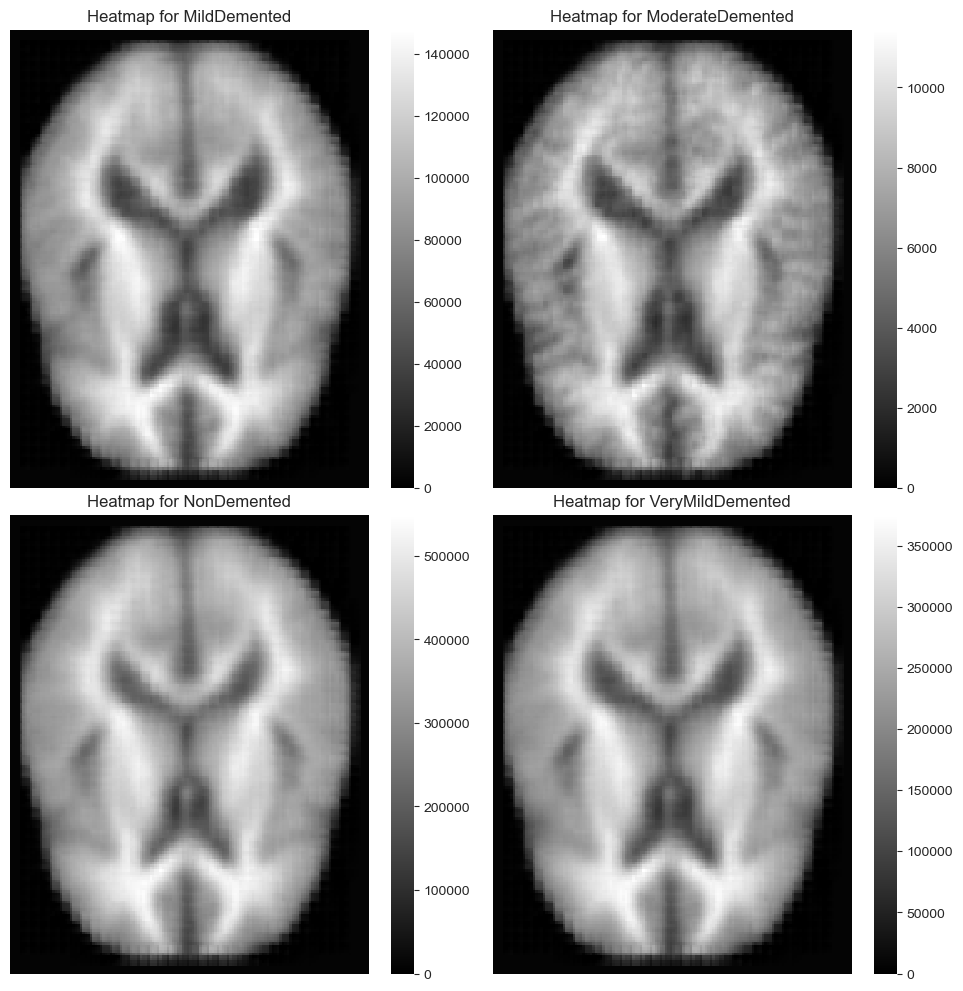

In [125]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10), sharey=True, sharex=True)
fig.tight_layout()

for i in range(len(classes)):
    ax = axes[i//2, i%2]
    class_images = decoded_images.squeeze().detach().numpy()[np.where(images_labels == i)]
    heatmap = np.sum(class_images, axis=0)
    sns.heatmap(heatmap, ax=ax, cmap='gray')
    ax.set_title(f'Heatmap for {classes[i]}')
    ax.get_yaxis().set_visible(False)
    ax.get_xaxis().set_visible(False)

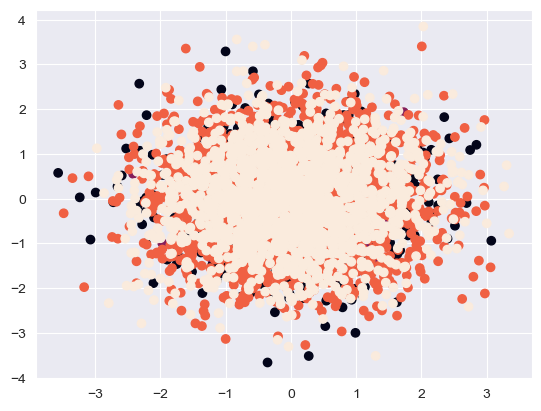

In [126]:
plt.scatter(encoded_images[:, 0], encoded_images[:, 1], c=images_labels)

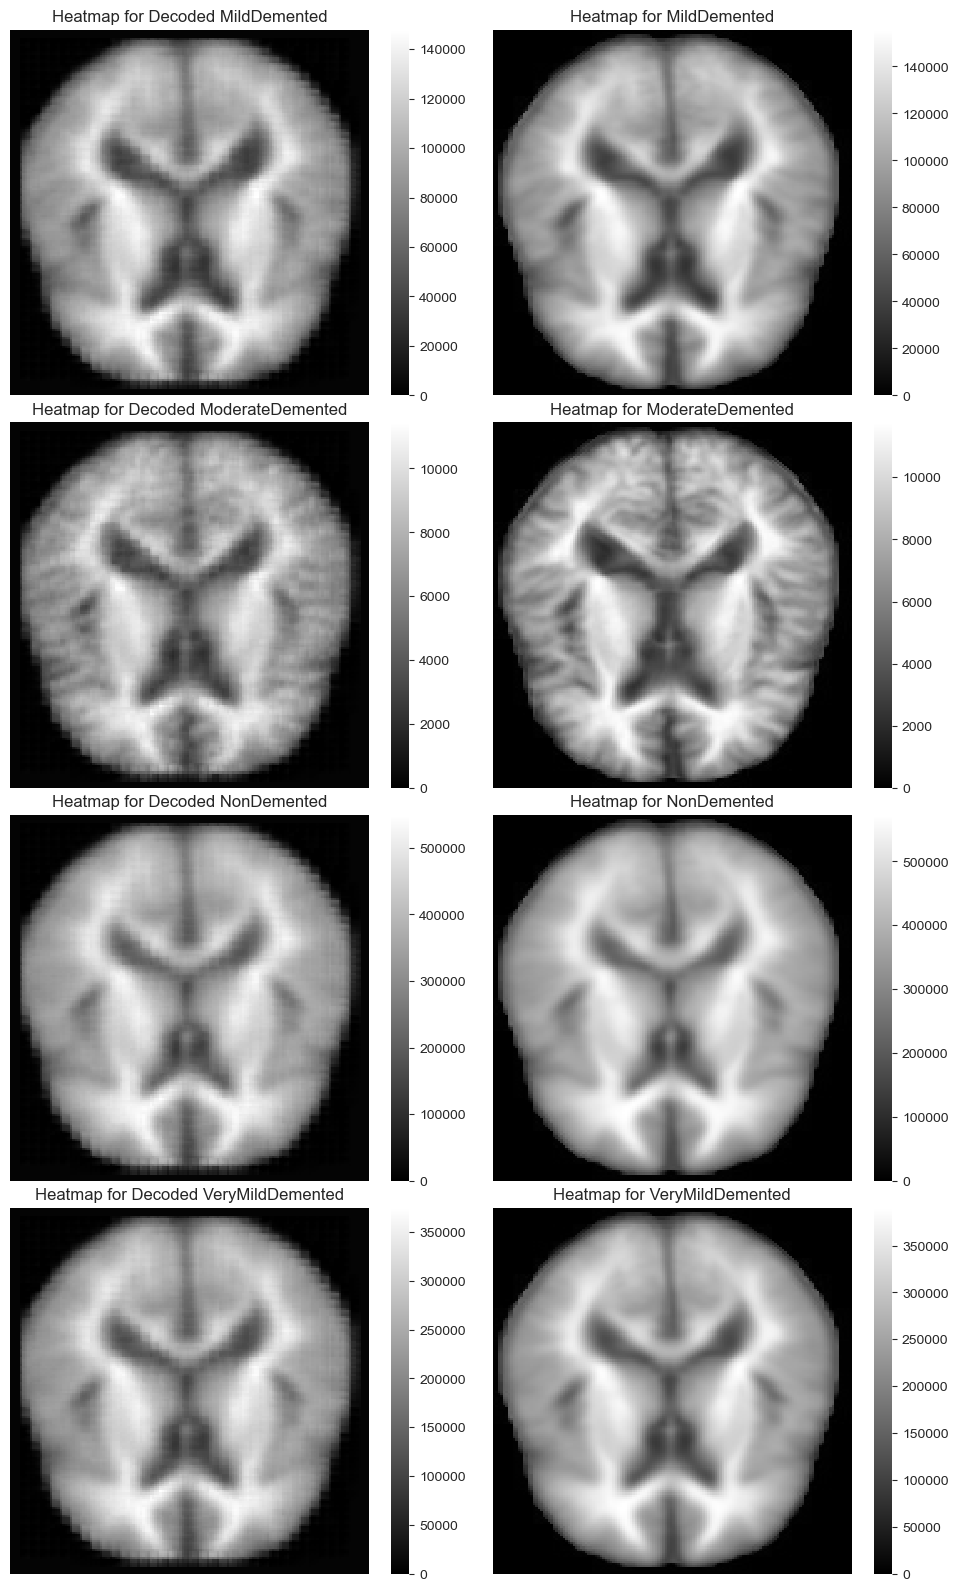

In [127]:
fig, axes = plt.subplots(4, 2, figsize=(10, 16), sharey=True, sharex=True)
fig.tight_layout()

for i in range(len(classes)):
    ax_generated = axes[i, 0]
    ax_original = axes[i, 1]
    generated_class_images = decoded_images.squeeze().detach().numpy()[np.where(images_labels == i)]
    original_class_images = images[np.where(images_labels == i)]
    original_heatmap = np.sum(original_class_images, axis=0)
    generated_heatmap = np.sum(generated_class_images, axis=0)
    sns.heatmap(generated_heatmap, ax=ax_generated, cmap='gray')
    sns.heatmap(original_heatmap, ax=ax_original, cmap='gray')
    
    ax_generated.set_title(f'Heatmap for Decoded {classes[i]}')
    ax_generated.get_yaxis().set_visible(False)
    ax_generated.get_xaxis().set_visible(False)
    
    ax_original.set_title(f'Heatmap for {classes[i]}')
    ax_original.get_yaxis().set_visible(False)
    ax_original.get_xaxis().set_visible(False)

In [128]:
from sklearn.neighbors import KNeighborsClassifier

k_neighbors = 7
knn = KNeighborsClassifier(n_neighbors=k_neighbors)
knn.fit(images.reshape(images.shape[0], -1), images_labels)

KNeighborsClassifier(n_neighbors=7)

In [129]:
@torch.no_grad()
def generate_images():
    # generate
    generated_images = decoder(torch.randn((len(images), encoded_dim)).to(device=device, dtype=torch.float32)).squeeze().cpu().numpy()
    # label each image by k nearest images in the original dataset
    generated_labels = knn.predict(generated_images.reshape(generated_images.shape[0], -1))
    
    return generated_images, generated_labels

(72, 176, 144)
(4, 176, 144)
(9748, 176, 144)
(418, 176, 144)


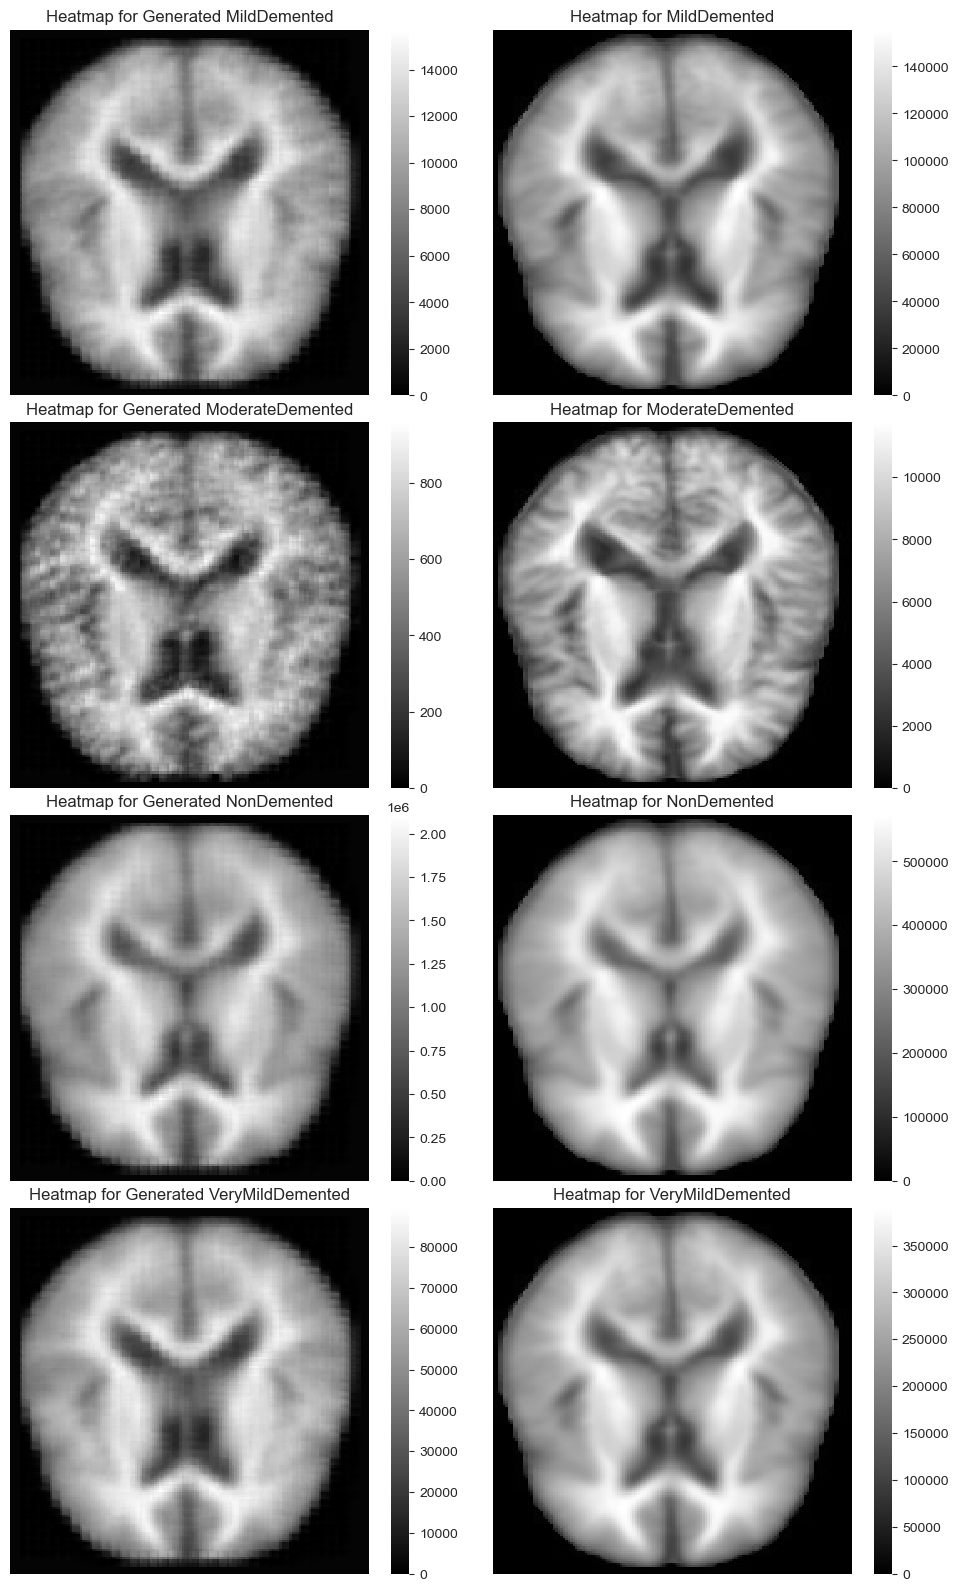

In [130]:
generated_images, generated_labels = generate_images()
gi, gl = generate_images()
generated_images, generated_labels = np.concatenate((generated_images, gi), axis=0), np.concatenate((generated_labels, gl), axis=0)

fig, axes = plt.subplots(4, 2, figsize=(10, 16), sharey=True, sharex=True)
fig.tight_layout()

for i in range(len(classes)):
    ax_generated = axes[i, 0]
    ax_original = axes[i, 1]
    
    generated_class_images = generated_images.squeeze()[np.where(generated_labels == i)]
    print(generated_class_images.shape)
    original_class_images = images[np.where(images_labels == i)]
    
    original_heatmap = np.sum(original_class_images, axis=0)
    generated_heatmap = np.sum(generated_class_images, axis=0)
    
    sns.heatmap(generated_heatmap, ax=ax_generated, cmap='gray')
    sns.heatmap(original_heatmap, ax=ax_original, cmap='gray')

    ax_generated.set_title(f'Heatmap for Generated {classes[i]}')
    ax_generated.get_yaxis().set_visible(False)
    ax_generated.get_xaxis().set_visible(False)

    ax_original.set_title(f'Heatmap for {classes[i]}')
    ax_original.get_yaxis().set_visible(False)
    ax_original.get_xaxis().set_visible(False)

In [131]:
#### Adding generated images to the dataset

In [132]:
final_images = np.concatenate((np.expand_dims(images, axis=1), decoded_images), axis=0)
final_labels = np.concatenate((images_labels, images_labels), axis=0)

In [133]:
final_images.shape, final_labels.shape

((10242, 1, 176, 144), (10242,))

(array([1434.,  104., 5120., 3584.]),
 array([0.  , 0.75, 1.5 , 2.25, 3.  ]),
 <BarContainer object of 4 artists>)

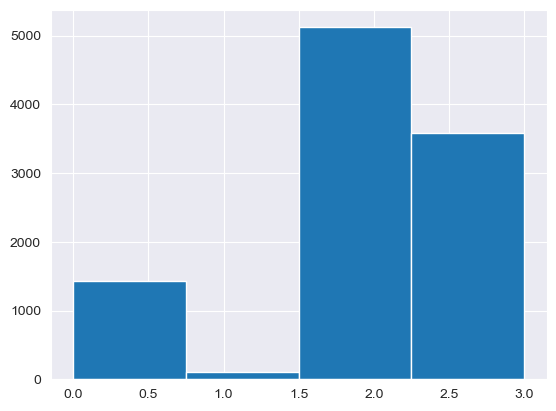

In [134]:
plt.hist(final_labels, bins=4)

In [159]:
def create_model_name(opt):
    final_name = f'{opt.__class__.__name__}-'
    for key, value in opt.state_dict()['param_groups'][0].items():
        if type(value) == type([]) or \
                key == 'differentiable' or \
                key == 'foreach' or \
                key == 'maximize' or \
                key == 'fused' or \
                key == 'nesterov':
            continue
        if key == 'lr':
            final_name += f'lr={lr}-'
            continue
        final_name += f'{key}={value}-'
    final_name += f'kl_lambda={kl_divergence_lambda}-'
    final_name += f'epochs={epochs}-'
    final_name += f'encoded_dim={encoded_dim}-'
    final_name += f'channels={initial_out_channels}-'
    final_name += f'bs={batch_size}'
    return final_name

In [160]:
def save_model(model, opt):
    file_name_prefix = f'./saved_models/{create_model_name(opt)}'
    file_name = f'{file_name_prefix}.pt'
    if os.path.exists(file_name):
        counter = 0
        file_name = f'{file_name_prefix}-{counter}.pt'
        while os.path.exists(file_name):
            print(f'file {file_name} already exists, creating a new file...')
            counter += 1
            file_name = f'{file_name_prefix}-{counter}.pt'
    torch.save(model.state_dict(), file_name)
    print(f'file {file_name} created.')

In [161]:
create_model_name(optimizer)

'SGD-lr=0.005183212977996399-momentum=0.2638754463591214-dampening=0.005483607192647268-weight_decay=0.13134430224387-initial_lr=0.005183212977996399-kl_lambda=3.9423241757246994-epochs=80-encoded_dim=2942-channels=8-bs=72'

In [158]:
save_model(autoencoder, optimizer)

RuntimeError: File ./saved_models/lr=0.005183212977996399-momentum=0.2638754463591214-dampening=0.005483607192647268-weight_decay=0.13134430224387-initial_lr=0.005183212977996399-kl_lambda=3.9423241757246994-epochs=80-encoded_dim=2942-channels=8-bs=72.pt cannot be opened.

In [109]:
overall_losses[-1], kl_divergence_losses[-1], mse_losses[-1]

(tensor(8159.2363), tensor(41.9501), tensor(8117.2861))